In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


In [4]:
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
parking_area,56897,9500.0
parking_price,46065,7710.0
txn_floor,15902,2639.0
village_income_median,1142,184.0


In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))
    
# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [6]:
#split features and labels
train_labels = train.pop('total_price')

features = pd.concat([train, test], keys=['train', 'test'])
features['parking_price'] = features['parking_price'].fillna(0)
features['village_income_median'] = features['village_income_median'].fillna(features['village_income_median'].mode()[0])
features['txn_floor'] = features['txn_floor'].fillna(features['txn_floor'].mode()[0])
features.drop(['parking_area'],axis = 1, inplace=True)
features.drop(['divorce_rate','death_rate','junior_rate','elementary_rate','highschool_rate'],axis = 1, inplace = True)
for feature in features:
    if 'index' in feature:
        features.drop([feature],axis = 1, inplace = True)
        
# Change the features to categorical
features['building_material'] = features['building_material'].astype(str)
features['city'] = features['city'].astype(str)
features['town'] = features['town'].astype(str)
features['building_type'] = features['building_type'].astype(str)
features['building_use'] = features['building_use'].astype(str)
features['parking_way'] = features['parking_way'].astype(str)

print("train : " + str(train.shape))

train : (60000, 234)


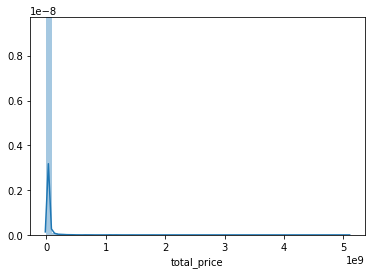

In [7]:
ax = sns.distplot(train_labels)

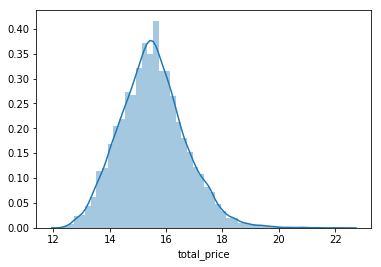

In [8]:
# Do log transformation of labels.
train_labels = np.log1p(train_labels)
ax = sns.distplot(train_labels)

In [9]:
# # parking NA means no parking space.
# for col in ('parking_area','parking_price'):
#     features[col] = features[col].fillna(0)
    
# # village_income_median NA. Filling with most popular values
# features['village_income_median'] = features['village_income_median'].fillna(features['village_income_median'].mode()[0])

# # Change the features to categorical
# features['building_material'] = features['building_material'].astype(str)
# features['city'] = features['city'].astype(str)
# features['town'] = features['town'].astype(str)
# features['building_type'] = features['building_type'].astype(str)
# features['building_use'] = features['building_use'].astype(str)
# features['parking_way'] = features['parking_way'].astype(str)

# for feature in features:
#     if 'index' in feature:
#         features[feature] = features[feature].astype(str)
features["XIII_5000-s2"] = features["XIII_5000"] ** 2
features["XIII_5000-s3"] = features["XIII_5000"] ** 3
features["XIII_5000-Sq"] = np.sqrt(features["XIII_5000"])
features["jobschool_rate-s2"] = features["jobschool_rate"] ** 2
features["jobschool_rate-s3"] = features["jobschool_rate"] ** 3
features["jobschool_rate-Sq"] = np.sqrt(features["jobschool_rate"])
features["bachelor_rate-s2"] = features["bachelor_rate"] ** 2
features["bachelor_rate-s3"] = features["bachelor_rate"] ** 3
features["bachelor_rate-Sq"] = np.sqrt(features["bachelor_rate"])
features["XIII_10000-s2"] = features["XIII_10000"] ** 2
features["XIII_10000-s3"] = features["XIII_10000"] ** 3
features["XIII_10000-Sq"] = np.sqrt(features["XIII_10000"])
features["VII_10000-s2"] = features["VII_10000"] ** 2
features["VII_10000-s3"] = features["VII_10000"] ** 3
features["VII_10000-Sq"] = np.sqrt(features["VII_10000"])
features["IX_10000-s2"] = features["IX_10000"] ** 2
features["IX_10000-s3"] = features["IX_10000"] ** 3
features["IX_10000-Sq"] = np.sqrt(features["IX_10000"])
print("features : " + str(features.shape))



features : (70000, 176)


In [10]:
categorical_features = features.select_dtypes(include = ["object"]).columns
numerical_features = features.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
features_num = features[numerical_features]
features_cat = features[categorical_features]

Numerical features : 169
Categorical features : 7


In [11]:
skewness = features_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 1.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
features_num[skewed_features] = np.log1p(features_num[skewed_features])

95 skewed numerical features to log transform


In [12]:
# numeric_features = features.loc[:,['total_floor','txn_dt','building_complete_dt','parking_area','parking_price','land_area','building_area',
#                                     'village_income_median','town_population','town_area','town_population_density','master_rate','bachelor_rate','highschool_rate','jobschool_rate','junior_rate','born_rate','death_rate',
#                                     'marriage_rate','divorce_rate']]
# numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
features_cat.drop(['building_id'],axis = 1,inplace = True)
features_cat = pd.get_dummies(features_cat)
print(features_cat)

            building_material_1  building_material_10  building_material_11  \
train 0                       0                     0                     0   
      1                       0                     0                     0   
      2                       0                     0                     0   
      3                       0                     0                     0   
      4                       1                     0                     0   
      5                       0                     0                     0   
      6                       0                     0                     0   
      7                       0                     0                     0   
      8                       0                     0                     0   
      9                       0                     0                     0   
      10                      1                     0                     0   
      11                      0                     

In [13]:
### Copying features
# features_standardized = features.copy()

# ### Replacing numeric features by standardized values
# features_standardized.update(numeric_features_standardized)

In [14]:
features = pd.concat([features_num, features_cat], axis = 1)
### Splitting features
train_features = features.loc['train'].select_dtypes(include=[np.number]).values
test_features = features.loc['test'].select_dtypes(include=[np.number]).values

### Splitting standardized features
# train_features_st = features_standardized.loc['train'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values
# test_features_st = features_standardized.loc['test'].drop('building_id', axis=1).select_dtypes(include=[np.number]).values

In [15]:
### Shuffling train sets
# train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)
train_features, train_labels = shuffle(train_features, train_labels, random_state = 5)


In [16]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
# x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

In [17]:
# ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(x_train_st, y_train_st)
# train_test(ENSTest, x_train_st, x_test_st, y_train_st, y_test_st)

In [18]:
# # Average R2 score and standart deviation of 5-fold cross-validation
# scores = cross_val_score(ENSTest, train_features_st, train_labels, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [19]:
import xgboost as xgb
# GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
#                                                min_samples_leaf=15, min_samples_split=10, loss='huber').fit(x_train, y_train)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
# train_test(GBest, x_train_st, x_test_st, y_train_st, y_test_st)



In [20]:
# Average R2 score and standart deviation of 5-fold cross-validation
scores = cross_val_score(model_xgb, train_features, train_labels, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.00)


ImportError: You must install graphviz to plot tree

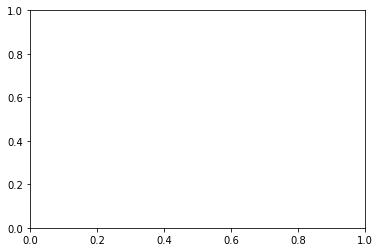

In [21]:
# Retraining models
# GB_model = GBest.fit(train_features, train_labels)
model_xgb_model = model_xgb.fit(train_features,train_labels)

# ENST_model = ENSTest.fit(train_features_st, train_labels)

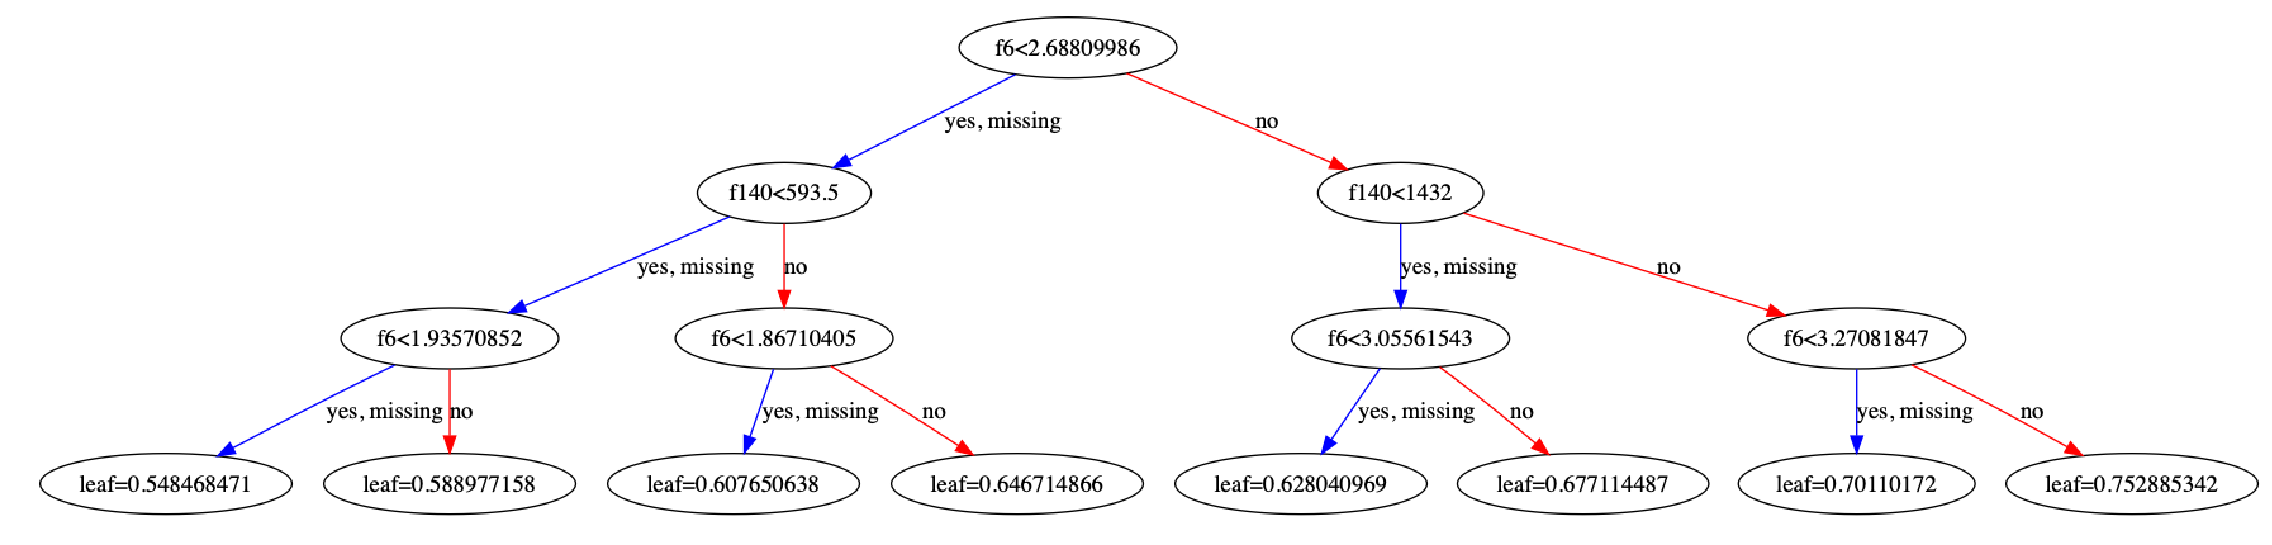

In [30]:
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(40, 40))
xgb.plot_tree(model_xgb_model, num_trees=4, ax=ax)
# plt.savefig("xgb_tree.jpg")
plt.show()


In [ ]:
## Getting our SalePrice estimation
# Final_labels = (np.exp(GB_model.predict(test_features)) + np.exp(ENST_model.predict(test_features_st))) / 2
# Final_labels = (np.exp(GB_model.predict(test_features)))
Final_labels = (np.exp(model_xgb_model.predict(test_features)))



In [ ]:
## Saving to CSV
pd.DataFrame({'building_id': test.building_id, 'total_price': Final_labels}).to_csv('2019-06-24_xg.csv', index =False) 